# Recomendação de livros - Collaborative filtering (FastAI)

## Autor

Lucas Gabriel Bezerra - 180125770

GitHub: [lucasgbezerra](https://github.com/lucasgbezerra/)

## Objetivo

O objetivo desse artigo é treinar um modelo capaz fazer recomendações de livros com base nas avaliações do usuário sobre os livros

## Motivo

A recomendação é extremamente explorada pelos serviçõs de streaming, video e música, atualmente, uma das maneiras de realizar a recomendação é utilizar a técnica Collaborative filtering. 

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/book-recommendation-dataset/Ratings.csv
/kaggle/input/book-recommendation-dataset/Users.csv
/kaggle/input/book-recommendation-dataset/Books.csv


## DataSet

Para criar o modelo, irei utilizar um conjunto de dados de livros. Ele é composto por 3 arquivos CSV: Books, que possui as informações sobre os livros; Ratings, que possui a nota dos usuários sobre os livros e Users que possui informações sobre os usuários.

In [2]:
books = pd.read_csv('/kaggle/input/book-recommendation-dataset/Books.csv')
ratings = pd.read_csv('/kaggle/input/book-recommendation-dataset/Ratings.csv')
users = pd.read_csv('/kaggle/input/book-recommendation-dataset/Users.csv')

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [4]:
books.loc[books['Book-Title'] == 'Harry Potter and the Goblet of Fire (Book 4)']

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
5431,0439139597,Harry Potter and the Goblet of Fire (Book 4),J. K. Rowling,2000,Scholastic,http://images.amazon.com/images/P/0439139597.0...,http://images.amazon.com/images/P/0439139597.0...,http://images.amazon.com/images/P/0439139597.0...
6932,0439139600,Harry Potter and the Goblet of Fire (Book 4),J. K. Rowling,2002,Scholastic Paperbacks,http://images.amazon.com/images/P/0439139600.0...,http://images.amazon.com/images/P/0439139600.0...,http://images.amazon.com/images/P/0439139600.0...


In [5]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271359 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB


In [6]:
users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [7]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


In [8]:
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [9]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


São 271.360 livros, 278.858 usuários e 1.149.780 avaliações

Para realizar a técnica de collaborative filtering irei utilizar alguns dados dos livros como ISBN e nome, a nota dado pelo usuário e o id do usuário

Portanto, para facilitar irei fazer o merge dos dataframes books e ratings e excluir as colunas indesejadas.

## Preparando o conjunto de dados

In [10]:
df = ratings.merge(books, on='ISBN')
df = df[['User-ID', 'ISBN', 'Book-Rating', 'Book-Title']]
df = df.rename(columns={"User-ID": "user_id", "ISBN": "book_id", "Book-Rating": "rating", "Book-Title": "name"})

In [11]:
df.drop(index=df[df["rating"] == 0].index, inplace=True)

In [12]:
df.head()

,user_id,book_id,rating,name
1,2313,034545104X,5,Flesh Tones: A Novel
3,8680,034545104X,5,Flesh Tones: A Novel
4,10314,034545104X,9,Flesh Tones: A Novel
9,50403,034545104X,9,Flesh Tones: A Novel
13,63970,034545104X,8,Flesh Tones: A Novel


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 383842 entries, 1 to 1031135
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   user_id  383842 non-null  int64 
 1   book_id  383842 non-null  object
 2   rating   383842 non-null  int64 
 3   name     383842 non-null  object
dtypes: int64(2), object(2)
memory usage: 14.6+ MB


In [14]:
df.isnull().sum()

user_id    0
book_id    0
rating     0
name       0
dtype: int64

Agora temos um dataframe com 1.031.136 linhas, que representam as avaliações dos usuários para os livros

In [15]:
df["rating"].value_counts()

8     91804
10    71225
7     66402
9     60778
5     45355
6     31687
4      7617
3      5118
2      2375
1      1481
Name: rating, dtype: int64

<AxesSubplot:>

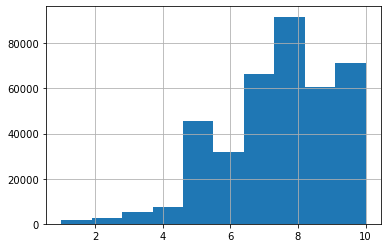

In [16]:
df["rating"].hist()

Como é possível notar boa parte tem o 0 que nessa base de dados simboliza a ausência de avaliação, portanto vamos remover do dataset

<AxesSubplot:>

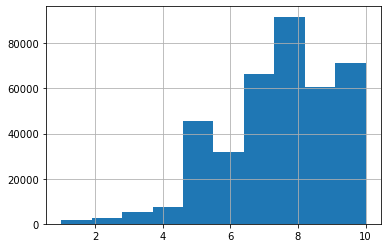

In [17]:
df.drop(index=df[df["rating"] == 0].index, inplace=True)
df["rating"].hist()

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 383842 entries, 1 to 1031135
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   user_id  383842 non-null  int64 
 1   book_id  383842 non-null  object
 2   rating   383842 non-null  int64 
 3   name     383842 non-null  object
dtypes: int64(2), object(2)
memory usage: 22.7+ MB


In [19]:
df['user_id'].nunique()

68091

In [20]:
df['book_id'].nunique()

149836

O dataframe agora foi reduzido para 383.842 linhas. Sendo que ele possui 68.091 usuários e 149.836 livros.

In [21]:
merged_sub = df.copy()

## Treinamento

### O que é Collaborative Filtering
Antes de começar vamos definir o que é o Collaborative filtering.

A filtragem colaborativa, uma técnica utilizada por alguns sistemas de recomendação, que usa semelhanças entre usuários e itens simultaneamente para fornecer recomendações. Isso permite recomendações casuais, ou seja, modelos de filtragem colaborativas podem recomendar um item para o usuário A com base nos interesses de um usuário B semelhante.

Para aplicar a técnica irei utilizar o framework fastaAi

In [22]:
from fastai.collab import *
from fastai.tabular.all import *
set_seed(42)

dls = CollabDataLoaders.from_df(merged_sub, item_name='name', user_name='user_id', rating_name='rating',bs=64)
dls.show_batch()

,user_id,name,rating
0,262634,Critical Mass,5
1,43910,Lily White,9
2,275573,Schlafes Bruder,10
3,189688,Singing in the Comeback Choir,7
4,47401,Small Miracles: Extraordinary Coincidences from Everyday Life,8
5,260429,When the Wind Blows,7
6,272786,Where the Heart Is (Oprah's Book Club (Paperback)),8
7,107865,Word Painting: A Guide to Writing More Descriptively,8
8,151727,The Borribles: Across the Dark Metropolis,4
9,185233,The Very Lonely Firefly,5


O fastAi possui um módulo voltado para o filtro colaborativo.

Ele possui o CollabDataLoaders que é  baseado no DataLoaders só que para filtragem colaborativa.

o dataloader é composto pelo dataframe, o nome do item à recomendar, o id do usuário e a avaliação, além da batchSize, presente no DataLoader padrão do fastaAi


Após criar o dataloader o fastai pode criar e treinar um modelo de filtragem colaborativa usando **collab_learner**.

In [23]:
learn = collab_learner(dls, n_factors=50, y_range=[0, 10])

O learn criado usa um modelo de produto escalar(EmbeddingDotBias) simples com 50 fatores latentes, esse é o padrão do collab_learner.

O EmbeddingDotBias é um módulo PyTorch usado para implementar algoritmos de fatoração de matrizes. Ele combina uma camada de incorporação e um termo de viés(bias) para representar usuários e itens como vetores em um espaço de baixa dimensão. Esses vetores são então usados para fazer previsões sobre interações usuário-item. O produto escalar entre os vetores de usuário e item representa a interação prevista, enquanto o termo de viés(bias) representa a previsão de linha de base para todos os usuários e itens.

SuggestedLRs(valley=0.25118863582611084)

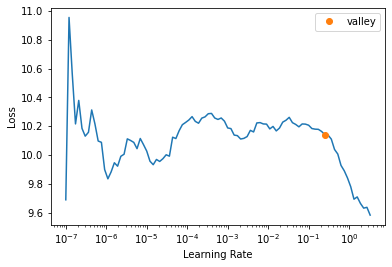

In [24]:
learn.lr_find()

In [26]:
learn.fit_one_cycle(5, 0.1, wd=0.1)

epoch,train_loss,valid_loss,time
0,6.199307,6.363077,01:03
1,6.265215,6.397398,01:03
2,5.836273,6.005852,01:03
3,5.405835,5.468482,01:04
4,5.225446,5.249245,01:03


In [27]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(59960, 50)
  (i_weight): Embedding(135568, 50)
  (u_bias): Embedding(59960, 1)
  (i_bias): Embedding(135568, 1)
)

## Interpretando os resultados do model

### Analisando o fator latent bias

In [32]:
book_bias = learn.model.i_bias.weight.squeeze()
idxs = book_bias.argsort(descending=True)[:1000]
top1000 = [dls.classes['name'][i] for i in idxs]
top1000

['To Kill a Mockingbird',
 'Harry Potter and the Goblet of Fire (Book 4)',
 "Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))",
 'The Secret Life of Bees',
 'Harry Potter and the Chamber of Secrets (Book 2)',
 'The Two Towers (The Lord of the Rings, Part 2)',
 'Harry Potter and the Order of the Phoenix (Book 5)',
 'The Lovely Bones: A Novel',
 'The Da Vinci Code',
 'Harry Potter and the Prisoner of Azkaban (Book 3)',
 'Fahrenheit 451',
 'The Fellowship of the Ring (The Lord of the Rings, Part 1)',
 "Tuesdays with Morrie: An Old Man, a Young Man, and Life's Greatest Lesson",
 "Ender's Game (Ender Wiggins Saga (Paperback))",
 'The Red Tent (Bestselling Backlist)',
 "Where the Heart Is (Oprah's Book Club (Paperback))",
 'Fast Food Nation: The Dark Side of the All-American Meal',
 'A Prayer for Owen Meany',
 'Life of Pi',
 '1984',
 'The Joy Luck Club',
 'Girl with a Pearl Earring',
 'Nickel and Dimed: On (Not) Getting By in America',
 'Angels &amp; Demons',
 'Prodigal Summe

O modelo aprendeu um bias por livro, um número único independente dos usuários que pode ser interpretado como o “valor” intrínseco do livro. 

In [33]:
mean_ratings = df.groupby('name')['rating'].mean()
book_bias = learn.model.bias(top100, is_item=True)
book_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top1000,book_bias)]

Livros com os 10 maiores bias

In [34]:
sorted(book_ratings, key=lambda o:o[0], reverse=True)[:10]

[(tensor(1.1178), 'To Kill a Mockingbird', 8.97752808988764),
 (tensor(1.0852),
  'Harry Potter and the Goblet of Fire (Book 4)',
  9.125506072874494),
 (tensor(1.0781),
  "Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))",
  8.936507936507937),
 (tensor(1.0485), 'The Secret Life of Bees', 8.47783251231527),
 (tensor(1.0141),
  'Harry Potter and the Chamber of Secrets (Book 2)',
  8.840490797546012),
 (tensor(1.0091),
  'The Two Towers (The Lord of the Rings, Part 2)',
  9.330882352941176),
 (tensor(0.9829),
  'Harry Potter and the Order of the Phoenix (Book 5)',
  9.04739336492891),
 (tensor(0.9771), 'The Lovely Bones: A Novel', 8.185289957567186),
 (tensor(0.9762), 'The Da Vinci Code', 8.43927125506073),
 (tensor(0.9631),
  'Harry Potter and the Prisoner of Azkaban (Book 3)',
  9.04332129963899)]

### Analisando o fator latente weight

Um gráfico com a diminuição de dimensões (de 50 para 3) usando o PCA  para extrair as informações mais importantes e ver como os livros estão espalhados em uma dimensão inferior.

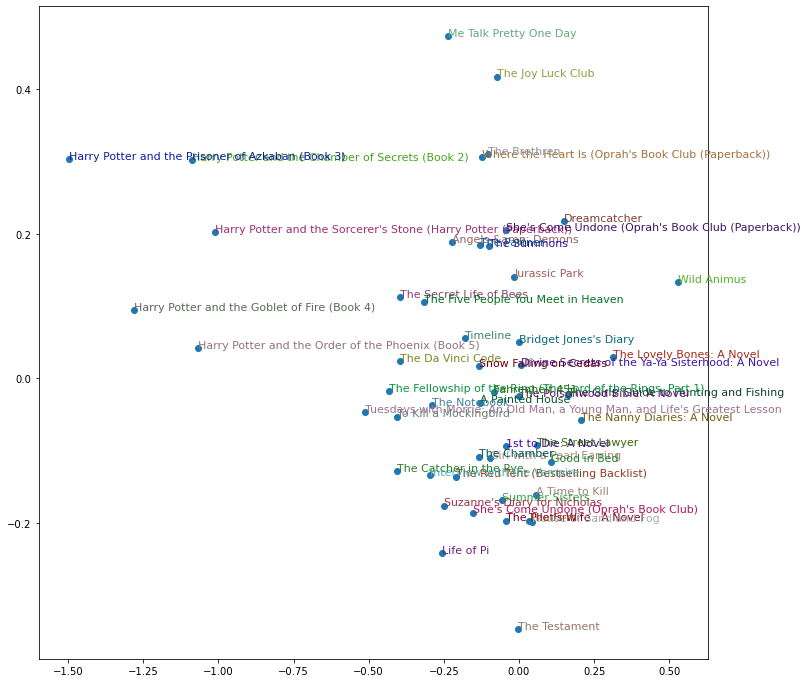

In [35]:
g = merged_sub.groupby('name')['rating'].count()
top_books = g.sort_values(ascending=False).index.values[:1000]
top_idxs = tensor([learn.dls.classes['name'].o2i[m] for m in top_books])
book_w = learn.model.i_weight.weight[top_idxs].cpu().detach()
book_pca = book_w.pca(3)
fac0,fac1,fac2 = book_pca.t()
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(12,12))
plt.scatter(X, Y)
for i, x, y in zip(top_books[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

## Testando o modelo

Utilizando o pesso para fazer recomendações a partir da similaridade

nn.CosineSimilarity é um módulo PyTorch que calcula a semelhança de cosseno entre dois tensores. 

A similaridade do cosseno é uma medida de similaridade entre dois vetores diferentes de zero de um espaço de produto interno. É definido como o cosseno do ângulo entre os dois vetores. No contexto dos sistemas de recomendação, a similaridade de cosseno pode ser usada para calcular a similaridade entre dois usuários ou entre dois itens, com base em suas avaliações.

In [36]:
book_factors = learn.model.i_weight.weight
idx = dls.classes['name'].o2i["Harry Potter and the Goblet of Fire (Book 4)"]
distances = nn.CosineSimilarity(dim=1)(book_factors, book_factors[idx][None])
idx = distances.argsort(descending=True)[1]
dls.classes['name'][idx]

'Harry Potter and the Prisoner of Azkaban (Book 3)'

In [37]:
user_id = 275401

df_test = df.loc[df['user_id'] == user_id]
df_test

,user_id,book_id,rating,name
2323,275401,043935806X,9,Harry Potter and the Order of the Phoenix (Book 5)
12110,275401,0971880107,1,Wild Animus
12889,275401,0439064864,9,Harry Potter and the Chamber of Secrets (Book 2)
130846,275401,0439139600,9,Harry Potter and the Goblet of Fire (Book 4)
194721,275401,0439136350,9,Harry Potter and the Prisoner of Azkaban (Book 3)
196897,275401,0590353403,9,Harry Potter and the Sorcerer's Stone (Book 1)
420453,275401,0440213282,8,No Greater Love
614276,275401,0451213599,8,Four Past Midnight
708139,275401,0747241406,9,Skinner's Festival
1030599,275401,0929480384,8,Insomnia: A novel


In [38]:
d = {'user_id': [user_id, user_id, user_id, user_id], 
     'name': ['To Kill a Mockingbird', 
              'Life of Pi',
              "Bridget Jones's Diary",
              "Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))",
             ]}

test = pd.DataFrame(data=d)

In [39]:
testdl = learn.dls.test_dl(test)
preds = learn.get_preds(dl=testdl)
preds

(tensor([8.2817, 7.6926, 7.1876, 8.7847]), None)

Podemos perceber que o livro Bridget Jones's Diary é o com menor avaliação segundo a predição, o que faz sentido, visto o gosto do usuário ser voltado para livros de fantasia e o livro em questão ser um livro sobre romance.

In [41]:
learn.export('learn.pkl')

## Conclusão

O filtro colaborativo se mostrou muito bom para fazer recomendações a partir de classificações de vários usuário.

Nesse artigo foi utilizado o framework do fastAi (com o modelo EmbeddingDotBias) dedicado a filtro colaborativo, que se mostrou simples de implementar, mas talvez pela falta de lapidação da solução não se mostrou tão preciso.